# Understanding the Impact of Pre-Processing Text on Rotten Tomato Reviews

This notebook is the training half of the project. We are working on experimenting with different kinds of preprocessing and their affect on sentiment classification. We are using 3 main models: SVM, RF and MLP. These are being compared against a pre-trained distilbert.

We work through various combinations. These include stemming and lemming the data, then applying 1 - 3 grams of bag of words and term frequency inverse document frequency. We also use word embeddings and use the twitter 25 for our embeddings. Given the high (and sparse) dimensions that get created using bow and tfidf, we will also experiemnt with latent semantic analysis (LSA) (a directly applicable form of PCA). While the final LSA output shown in the notebook is for 2000 features, 100 and 1000 were also experimented, results of which were screen shotted and will be added to the appendix accompanying the report

The data set we are using is the rotten tomatoes dataset found here https://huggingface.co/datasets/rotten_tomatoes

## Installing the Packages

In [ ]:
#not all of these were needed but were used for testing at somepoint

#!pip install pandas==2.0.3
#!pip install scipy==1.13.0
#!pip install matplotlib==3.8.4
#!pip install seaborn==0.13.2
#!pip install scikit-learn==1.4.0
#!pip install torch==2.2.1
#!pip install skorch==0.15.0
#!pip install joblib==1.4.0
#!pip install tensorflow==2.15
#!pip install nltk==3.8.1
#!pip install spacy==3.7.4
#!python -m spacy download en_core_web_sm
#!pip install transformers==4.40.1
#!pip install gensim==4.3.2
!pip install datasets==2.19.0
!pip install nltk contractions==0.1.73

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 27.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 12.9 MB/s eta 0:00:00


## Importing Packages

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import string
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
import contractions
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
import joblib
from joblib import dump
from gensim.models import KeyedVectors
import gensim.downloader as api
from nltk.stem import PorterStemmer
from transformers import pipeline
from sklearn.decomposition import TruncatedSVD

## Data Import and Initial Pre-Processing

This section will focus on importing our data from hugging face and doing some initial pre-processing before some simple eda which will include removing punction, removing stop words, removing special characters and making everying lower case

In [ ]:
rt_data = load_dataset("rotten_tomatoes")
rt_data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [ ]:
#getting the data frames and making copies so that the original remains untouched

rt_df1 = pd.DataFrame(rt_data['train'])
rt_df2 = pd.DataFrame(rt_data['validation'])
rt_df3 = pd.DataFrame(rt_data['test'])

rt_df_train = rt_df1.copy()
rt_df_validation = rt_df2.copy()
rt_df_test = rt_df3.copy()

In [ ]:
rt_df_train

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1
...,...,...
8525,any enjoyment will be hinge from a personal th...,0
8526,if legendary shlockmeister ed wood had ever ma...,0
8527,hardly a nuanced portrait of a young woman's b...,0
8528,"interminably bleak , to say nothing of boring .",0


In [ ]:
#downloading nltk data used further down
#documentation: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#defining a preprocessing function that will lower case, remove stop words, specical characters and punctuation
#documentation: https://stackoverflow.com/questions/15547409/how-to-get-rid-of-punctuation-using-nltk-tokenizer
#documentation: https://www.w3schools.com/python/ref_string_maketrans.asp
#documentation: https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/

#could also just use count vectorizer but this way made the process more modular and easier to follow and more control

def review_preprocessing(reviews):

  #fixing contractions
  reviews = contractions.fix(reviews)

  #converts to lower case
  reviews = reviews.lower()

  #tokenise before removing punctuation so that words like can't dont get messed up
  #initally i did not do this and got some wonky results
  #then removing the punctuation from the tokens
  #then removing stop words
  tokens = word_tokenize(reviews)
  tokens_table = str.maketrans('', '', string.punctuation)
  no_punctuation_tokens = [words.translate(tokens_table) for words in tokens]

  #removing stop words by filtering out the stop words and joining them back
  stop_words = set(stopwords.words('english'))
  #adding an additional check in the filter since we are removing stop words from tokens from which we have removed punctuation which could retun ' '
  filter = [words for words in no_punctuation_tokens if words not in stop_words and words != '']
  reviews = ' '.join(filter)

  return reviews

#wanted to add some kind of processing to fix things like "soooo goooodd" but was not able to get the regex right so left it out

In [ ]:
rt_df_train['text'] = rt_df_train['text'].apply(review_preprocessing)
rt_df_validation['text'] = rt_df_validation['text'].apply(review_preprocessing)
rt_df_test['text'] = rt_df_test['text'].apply(review_preprocessing)

In [ ]:
#looks much cleaner
rt_df_train

,text,label
0,rock destined 21st century new conan going mak...,1
1,gorgeously elaborate continuation lord rings t...,1
2,effective tootepid biopic,1
3,sometimes like go movies fun wasabi good place...,1
4,emerges something rare issue movie honest keen...,1
...,...,...
8525,enjoyment hinge personal threshold watching sa...,0
8526,legendary shlockmeister ed wood ever made movi...,0
8527,hardly nuanced portrait young woman breakdown ...,0
8528,interminably bleak say nothing boring,0


## EDA

In [ ]:
#combining the data frames just for eda

rt_df_combined = pd.concat([rt_df_train, rt_df_validation, rt_df_test], ignore_index=True)
rt_df_combined

,text,label
0,rock destined 21st century new conan going mak...,1
1,gorgeously elaborate continuation lord rings t...,1
2,effective tootepid biopic,1
3,sometimes like go movies fun wasabi good place...,1
4,emerges something rare issue movie honest keen...,1
...,...,...
10657,terrible movie people nevertheless find moving,0
10658,many definitions time waster movie must surely...,0
10659,stands crocodile hunter hurried badly cobbled ...,0
10660,thing looks like madeforhomevideo quickie,0


In [ ]:
#quick summary of the number of words and reviews
#these are approximate as we are simply splitting on a single white space
#not accounting for double spaces or other variations

rt_df_combined['count'] = rt_df_combined['text'].apply(lambda x: len(str(x).split()))
#rt_df_combined

rt_df_combined['count'].describe()

count    10662.000000
mean        10.472519
std          4.795210
min          1.000000
25%          7.000000
50%         10.000000
75%         14.000000
max         39.000000
Name: count, dtype: float64

In [ ]:
#approximate total number of words

rt_df_combined['count'].sum()

111658

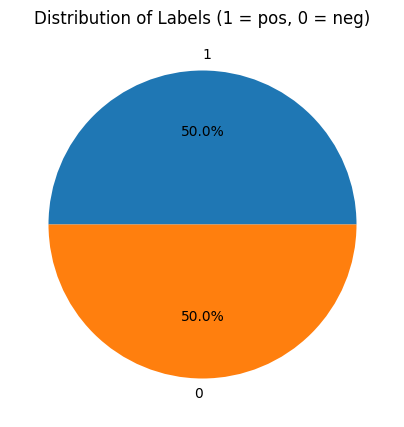

In [ ]:
#label distribution pie chart
#documentation: https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html

label_count = rt_df_combined['label'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(label_count, labels=label_count.index, autopct='%1.1f%%')
plt.title('Distribution of Labels (1 = pos, 0 = neg)')
plt.show()

#even distribution across the labels so we should not run into any imbalance problems

In [ ]:
#generating word clouds for the positive and negative reviews
#documentation: https://www.analyticsvidhya.com/blog/2021/05/how-to-build-word-cloud-in-python/
#documentation: https://www.datacamp.com/tutorial/wordcloud-python

#separating the positive and the negative reviews
positive_reviews = rt_df_combined[rt_df_combined['label'] == 1]['text']
negative_reviews = rt_df_combined[rt_df_combined['label'] == 0]['text']

#combining them all into a single string
positive_words = " ".join(positive_reviews)
negative_words = " ".join(negative_reviews)

#creating the word clouds
wordcloud_positive = WordCloud(width=500, height=500, background_color='white').generate(positive_words)
wordcloud_negative = WordCloud(width=500, height=500, background_color='white').generate(negative_words)

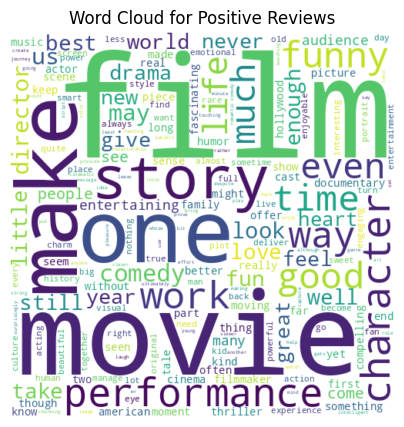

In [ ]:
#the positive cloud

plt.figure(figsize=(5, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Positive Reviews')
plt.show()

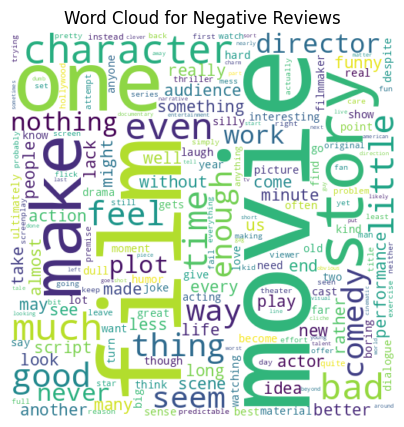

In [ ]:
#the negative cloud

plt.figure(figsize=(5, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Negative Reviews')
plt.show()

In [ ]:
#doing a quick sentiment score to see which way the data might be biased even though there is an even distribution of classes
#documentation: https://www.youtube.com/watch?v=QpzMWQvxXWk

df_positive = pd.DataFrame(positive_reviews, columns=['text'])
df_negative = pd.DataFrame(negative_reviews, columns=['text'])

sia = SentimentIntensityAnalyzer()

def compound_score(reviews):
    return sia.polarity_scores(reviews)['compound']

#applying the function rather than looping
df_positive['compound_score'] = df_positive['text'].apply(compound_score)
df_negative['compound_score'] = df_negative['text'].apply(compound_score)

average_positive = df_positive['compound_score'].mean()
average_negative = df_negative['compound_score'].mean()
median_positive = df_positive['compound_score'].median()
median_negative = df_negative['compound_score'].median()


print(f"Average Compound Score for Positive Reviews: {average_positive}")
print(f"Average Compound Score for Negative Reviews: {average_negative}")
print(f"Median Compound Score for Positive Reviews: {median_positive}")
print(f"Median Compound Score for Negative Reviews: {median_negative}")

#vader gives a score that is normalized between -1 and 1
#average positive score makes sense given that the number is positive signifiying positive sentiment
#it is not very close to 1 so not very high and the median also suggests that generally the scores are medium positive sentiment
#the negative sentiment is surprising given both the median and average are non negative
#a negative dataset should technically give a negative sentiment
#this could be because there is a lot of neutral language or some context that vader can not understand
#this would mean that doing some kind of POS might help make the machine learning models be less biased towards the positive sentiment
#we will experiment on our classifiers with and without this

Average Compound Score for Positive Reviews: 0.32885721253048206
Average Compound Score for Negative Reviews: 0.04437824048021009
Median Compound Score for Positive Reviews: 0.4404
Median Compound Score for Negative Reviews: 0.0


## Further Pre-Processed Dataset Combinations

We will be experimenting with various combinations of pre processing. They will include the following:

1. lemmatization bag of words (uni bi tri)
2. lemmatization tf idf (uni bi tri)
3. word embeddings
4. all the above, replace lemma with stem, word embeddings is on its own without lemma or stem


POS is used when doing lemmatization so it is being accounted for in the pipeline

We will also be doing stratified cross validation so we will combine the training and validation sets into one

This section will just create the different datasets to use for the classifiers

In [ ]:
  #making just a train and a test set


rt_df_train2 = pd.concat([rt_df_train, rt_df_validation], ignore_index=True)
rt_df_test2 = rt_df_test

### The Base Data

this is simply created using a count vectorizer with unigram

In [ ]:
rt_df_train_base= rt_df_train2.copy()
rt_df_test_base = rt_df_test2.copy()

vectorizer = CountVectorizer()

X_bow_uni = vectorizer.fit_transform(rt_df_train_base['text'])
y_bow_uni = rt_df_train_base['label']
X_bow_uni

<9596x18683 sparse matrix of type '<class 'numpy.int64'>'
	with 98874 stored elements in Compressed Sparse Row format>

### The Lemmatized Data

lemmatization generally involves understanding some extra context such as whether a word is a noun before reducing the word down to its lemma

this will be supplmented with POS so nouns, adjectives, verbs etc can be accounted for to get a more accurate lemma

In [ ]:
#we will be using wordnetlemmatizer
#however when doing some quick tests and reading the documentation it was always defaulting to noun
#see the running example
#to fix this had to write a functino that would pos tag, convert the pos tag to what the lemmatize function needs and then lemmatize

#documentation: https://www.nltk.org/_modules/nltk/stem/wordnet.html
#documentation: https://www.nltk.org/api/nltk.stem.wordnet.html#nltk.stem.WordNetLemmatizer.lemmatize


#wnl = WordNetLemmatizer()
#print(wnl.lemmatize('running'))
#print(wnl.lemmatize('running', pos='v'))

In [ ]:
#defining the function that will get the pos tags to pass to wordnet
#using some text manipulation functions found in python
#creating a simple list, more complicated lists could return better results
#we could specifiy more word forms or individual word forms like distinguish between great and greater
#we are just looking at verbs, adjectives and nouns
#documentation: https://www.w3schools.com/python/ref_string_startswith.asp
#documentation: https://medium.com/@neri.vvo/part-of-speech-pos-tagging-in-nlp-4-python-how-to-tutorials-a9b168720364

def get_pos(pos_tags):
    if pos_tags.startswith('V'):
        return wordnet.VERB
    elif pos_tags.startswith('J'):
        return wordnet.ADJ
    elif pos_tags.startswith('N'):
        return wordnet.NOUN
    else:
        return wordnet.NOUN

In [ ]:
#now creatinng the function to lemmatize using are pos tag finder above

def get_lemma(reviews):
    lemmatizer = WordNetLemmatizer() #instantiating the word net
    tokens = word_tokenize(reviews) #creating tokens
    tags = pos_tag(tokens) #getting tags for token
    reviews_lemmas = [lemmatizer.lemmatize(word, get_pos(tag)) for word, tag in tags] #list comprehension looping over the text and their tags
    return ' '.join(reviews_lemmas) #putting it all back together with a space if a sentence is passed

In [ ]:
#testing our function
#looks to be working with "run" family of words having the correct lemma

test = {'review': ["Do lions roar loudly", "runner", "running", "ran"]}
test_df = pd.DataFrame(test)

test_df['review_lemma'] = test_df['review'].apply(get_lemma)
test_df

,review,review_lemma
0,Do lions roar loudly,Do lion roar loudly
1,runner,runner
2,running,run
3,ran,ran


#### Lemma and Bag of Words (Uni Gram)

this is also the uni gram model where each word is treated as a separate feature

In [ ]:
#making copies so the origianl is unaffected
#we do not really need the test data right now but its fine
#we do not need the test data since we are cross validating and training
#testing will be in a different notebook

rt_df_train_lemma1 = rt_df_train2.copy()
rt_df_test_lemma1 = rt_df_test2.copy()

In [ ]:
rt_df_train_lemma1['text_lemma'] = rt_df_train_lemma1['text'].apply(get_lemma)
#rt_df_test_lemma1['text_lemma'] = rt_df_test_lemma1['text'].apply(get_lemma)

rt_df_train_lemma1

,text,label,text_lemma
0,rock destined 21st century new conan going mak...,1,rock destine 21st century new conan go make sp...
1,gorgeously elaborate continuation lord rings t...,1,gorgeously elaborate continuation lord ring tr...
2,effective tootepid biopic,1,effective tootepid biopic
3,sometimes like go movies fun wasabi good place...,1,sometimes like go movie fun wasabi good place ...
4,emerges something rare issue movie honest keen...,1,emerges something rare issue movie honest keen...
...,...,...,...
9591,picture murder numbers easy bored abc despite ...,0,picture murder number easy bore abc despite wh...
9592,hilarious musical comedy though stymied accent...,0,hilarious musical comedy though stymied accent...
9593,splatter movies probably reasonably good time ...,0,splatter movie probably reasonably good time s...
9594,dull simpleminded stereotypical tale drugs dea...,0,dull simpleminded stereotypical tale drug deat...


In [ ]:
vectorizer = CountVectorizer()

In [ ]:
#lemma and bag of words

X_lemma_bow_uni = vectorizer.fit_transform(rt_df_train_lemma1['text_lemma'])
y_lemma_bow_uni = rt_df_train_lemma1['label']
X_lemma_bow_uni

<9596x16008 sparse matrix of type '<class 'numpy.int64'>'
	with 98411 stored elements in Compressed Sparse Row format>

#### Lemma and Bag of Words (Bi Gram)

here we take 2 words together as a feature

In [ ]:
#resetting the dataframes

rt_df_train_lemma2 = rt_df_train2.copy()
rt_df_test_lemma2 = rt_df_test2.copy()

In [ ]:
#making the bi gram model with count vectorizer argument
#documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
#could also use max features argument but using all for now
#max features can help decrease compute time and over fitting

vectorizer = CountVectorizer(ngram_range=(2, 2))

In [ ]:
rt_df_train_lemma2['text_lemma'] = rt_df_train_lemma2['text'].apply(get_lemma)

In [ ]:
X_lemma_bow_bi = vectorizer.fit_transform(rt_df_train_lemma2['text_lemma'])
y_lemma_bow_bi = rt_df_train_lemma2['label']
X_lemma_bow_bi

<9596x79014 sparse matrix of type '<class 'numpy.int64'>'
	with 90123 stored elements in Compressed Sparse Row format>

#### Lemma and Bag of Words (Tri Gram)
here we take 3 words together as a feature

In [ ]:
#resetting the dataframes

rt_df_train_lemma3 = rt_df_train2.copy()
rt_df_test_lemma3 = rt_df_test2.copy()

In [ ]:
vectorizer = CountVectorizer(ngram_range=(3, 3))

In [ ]:
rt_df_train_lemma3['text_lemma'] = rt_df_train_lemma3['text'].apply(get_lemma)

In [ ]:
X_lemma_bow_tri = vectorizer.fit_transform(rt_df_train_lemma3['text_lemma'])
y_lemma_bow_tri = rt_df_train_lemma3['label']
X_lemma_bow_tri

<9596x79966 sparse matrix of type '<class 'numpy.int64'>'
	with 80643 stored elements in Compressed Sparse Row format>

#### Lemma and TF IDF (Uni Gram)

tf idf is term frequency - inverse document frequency

it builds upon the bag of words feature extraction by normalizing the vectors to the total number of words

we can think of it as a normalized bag of words. this is also why in our pipeline we will not be implenting a standard scaler on the bag of words. this will serve as a comparison point

our distance based and gradient based algorithms (SVM and MLP) might preform better using TF *IDF*

In [ ]:
rt_df_train_lemma4 = rt_df_train2.copy()
rt_df_test_lemma4 = rt_df_test2.copy()

In [ ]:
vectorizer = TfidfVectorizer()

In [ ]:
rt_df_train_lemma4['text_lemma'] = rt_df_train_lemma4['text'].apply(get_lemma)

In [ ]:
X_lemma_tfidf_uni = vectorizer.fit_transform(rt_df_train_lemma4['text_lemma'])
y_lemma_tfidf_uni = rt_df_train_lemma4['label']
X_lemma_tfidf_uni

<9596x16008 sparse matrix of type '<class 'numpy.float64'>'
	with 98411 stored elements in Compressed Sparse Row format>

#### Lemma and TF IDF (Bi Gram)

In [ ]:
rt_df_train_lemma5 = rt_df_train2.copy()
rt_df_test_lemma5 = rt_df_test2.copy()

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(2, 2))

In [ ]:
rt_df_train_lemma5['text_lemma'] = rt_df_train_lemma5['text'].apply(get_lemma)

In [ ]:
X_lemma_tfidf_bi = vectorizer.fit_transform(rt_df_train_lemma5['text_lemma'])
y_lemma_tfidf_bi = rt_df_train_lemma5['label']
X_lemma_tfidf_bi

<9596x79014 sparse matrix of type '<class 'numpy.float64'>'
	with 90123 stored elements in Compressed Sparse Row format>

#### Lemma and TF IDF (Tri Gram)

In [ ]:
rt_df_train_lemma6 = rt_df_train2.copy()
rt_df_test_lemma6 = rt_df_test2.copy()

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(3, 3))

In [ ]:
rt_df_train_lemma6['text_lemma'] = rt_df_train_lemma6['text'].apply(get_lemma)

In [ ]:
X_lemma_tfidf_tri = vectorizer.fit_transform(rt_df_train_lemma6['text_lemma'])
y_lemma_tfidf_tri = rt_df_train_lemma6['label']
X_lemma_tfidf_tri

<9596x79966 sparse matrix of type '<class 'numpy.float64'>'
	with 80643 stored elements in Compressed Sparse Row format>

#### Lemma and Word Embeddings

we will be using the pre trained models and then taking an average to make it useable for svm, rf and mlp since they will require the single input

documentation: https://intapi.sciendo.com/pdf/10.2478/icas-2019-0043

In [ ]:
rt_df_train_lemma7 = rt_df_train2.copy()
rt_df_test_lemma7 = rt_df_test2.copy()

In [ ]:
#documentation for working with pre trained word2vec
#documentation: https://radimrehurek.com/gensim/models/keyedvectors.html
#documentation: https://stackoverflow.com/questions/46433778/import-googlenews-vectors-negative300-bin
#documentation: https://radimrehurek.com/gensim/downloader.html

#print(api.info()['models'].keys())

#while google news is a large file it is quite popular. this might preform better
#but we will use glove twitter 25 which is smaller and more representative of our data
#hypotehtically twitter post language maybe similar to reviews
model = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
#since we are using a smaller embedding dataset, we will supplement this by using lemma
rt_df_train_lemma7['text_lemma'] = rt_df_train_lemma7['text'].apply(get_lemma)

In [ ]:
#creating a function to use the pre trained embeddings
#we need to get them for each word and if they dont exist then we need to return a 0 vector
#then we average
#documentation: https://blog.paperspace.com/pre-trained-word-embeddings-natural-language-processing/

def get_embeddings(model, review):

    tokens = [word for word in review.split() if word in model.key_to_index]
    if not tokens:
        return np.zeros(model.vector_size)
    token_vectors = [model[word] for word in tokens]

    #averaging given the paper https://intapi.sciendo.com/pdf/10.2478/icas-2019-0043
    vector = np.mean(token_vectors, axis=0)
    return vector

In [ ]:
#applying our function
rt_df_train_lemma7['text_embeddings'] = rt_df_train_lemma7['text_lemma'].apply(lambda x: get_embeddings(model, x))

In [ ]:
#rt_df_train_lemma7

In [ ]:
X_lemma_we = np.array(list(rt_df_train_lemma7['text_embeddings']))
y_lemma_we = rt_df_train_lemma7['label']

### The Stemmed Data

we will now repeat the lemma process except this time we will stem the data to see which will preform better

In [ ]:
#creating the stemming function

stemmer = PorterStemmer()

def get_stem(reviews):
    tokens = word_tokenize(reviews)
    reviews_stems = [stemmer.stem(token) for token in tokens]
    return ' '.join(reviews_stems)

##### Stem and Bag of Words (Uni Gram)

In [ ]:
#resetting the dataframes

rt_df_train_stem1= rt_df_train2.copy()
rt_df_test_stem1 = rt_df_test2.copy()

In [ ]:
rt_df_train_stem1['text_stem'] = rt_df_train_stem1['text'].apply(get_stem)

In [ ]:
#the output is already looking worse with some things not even words
#not expecting this to preform well at all
rt_df_train_stem1.head(3)

,text,label,text_stem
0,rock destined 21st century new conan going mak...,1,rock destin 21st centuri new conan go make spl...
1,gorgeously elaborate continuation lord rings t...,1,gorgeous elabor continu lord ring trilog huge ...
2,effective tootepid biopic,1,effect tootepid biopic


In [ ]:
vectorizer = CountVectorizer()

In [ ]:
X_stem_bow_uni = vectorizer.fit_transform(rt_df_train_stem1['text_stem'])
y_stem_bow_uni = rt_df_train_stem1['label']
X_stem_bow_uni

<9596x13645 sparse matrix of type '<class 'numpy.int64'>'
	with 98622 stored elements in Compressed Sparse Row format>

##### Stem and Bag of Words (Bi Gram)

In [ ]:
rt_df_train_stem2= rt_df_train2.copy()
rt_df_test_stem2 = rt_df_test2.copy()

rt_df_train_stem2['text_stem'] = rt_df_train_stem2['text'].apply(get_stem)

vectorizer = CountVectorizer(ngram_range=(2, 2))

X_stem_bow_bi = vectorizer.fit_transform(rt_df_train_stem2['text_stem'])
y_stem_bow_bi = rt_df_train_stem2['label']
X_stem_bow_bi

<9596x78797 sparse matrix of type '<class 'numpy.int64'>'
	with 90402 stored elements in Compressed Sparse Row format>

##### Stem and Bag of Words (Tri Gram)

In [ ]:
rt_df_train_stem3= rt_df_train2.copy()
rt_df_test_stem3 = rt_df_test2.copy()

rt_df_train_stem3['text_stem'] = rt_df_train_stem3['text'].apply(get_stem)

vectorizer = CountVectorizer(ngram_range=(3, 3))

X_stem_bow_tri = vectorizer.fit_transform(rt_df_train_stem3['text_stem'])
y_stem_bow_tri = rt_df_train_stem3['label']
X_stem_bow_tri

<9596x80227 sparse matrix of type '<class 'numpy.int64'>'
	with 80925 stored elements in Compressed Sparse Row format>

##### Stem and TF IDF (Uni Gram)

In [ ]:
rt_df_train_stem4= rt_df_train2.copy()
rt_df_test_stem4 = rt_df_test2.copy()

rt_df_train_stem4['text_stem'] = rt_df_train_stem4['text'].apply(get_stem)

stem_tfidf_uni_vectorizer = TfidfVectorizer()

X_stem_tfidf_uni = stem_tfidf_uni_vectorizer.fit_transform(rt_df_train_stem4['text_stem'])

dump(stem_tfidf_uni_vectorizer, 'stem_tfidf_uni_vectorizer.joblib')

y_stem_tfidf_uni = rt_df_train_stem4['label']
X_stem_tfidf_uni

<9596x13645 sparse matrix of type '<class 'numpy.float64'>'
	with 98622 stored elements in Compressed Sparse Row format>

##### Stem and TF IDF (Bi Gram)

In [ ]:
rt_df_train_stem5 = rt_df_train2.copy()
rt_df_test_stem5 = rt_df_test2.copy()

rt_df_train_stem5['text_stem'] = rt_df_train_stem5['text'].apply(get_stem)

vectorizer = TfidfVectorizer(ngram_range=(2, 2))

X_stem_tfidf_bi = vectorizer.fit_transform(rt_df_train_stem5['text_stem'])
y_stem_tfidf_bi = rt_df_train_stem5['label']
X_stem_tfidf_bi

<9596x78797 sparse matrix of type '<class 'numpy.float64'>'
	with 90402 stored elements in Compressed Sparse Row format>

##### Stem and TF IDF (Tri Gram)

In [ ]:
rt_df_train_stem6 = rt_df_train2.copy()
rt_df_test_stem6 = rt_df_test2.copy()

rt_df_train_stem6['text_stem'] = rt_df_train_stem6['text'].apply(get_stem)

vectorizer = TfidfVectorizer(ngram_range=(3, 3))

X_stem_tfidf_tri = vectorizer.fit_transform(rt_df_train_stem6['text_stem'])
y_stem_tfidf_tri = rt_df_train_stem6['label']
X_stem_tfidf_tri

<9596x80227 sparse matrix of type '<class 'numpy.float64'>'
	with 80925 stored elements in Compressed Sparse Row format>

##### Stem and Word Embeddings

In [ ]:
rt_df_train_stem7 = rt_df_train2.copy()
rt_df_test_stem7 = rt_df_test2.copy()

rt_df_train_stem7['text_stem'] = rt_df_train_stem7['text'].apply(get_stem)

rt_df_train_stem7['text_embeddings'] = rt_df_train_stem7['text_stem'].apply(lambda x: get_embeddings(model, x))

X_stem_we = np.array(list(rt_df_train_stem7['text_embeddings']))
y_stem_we = rt_df_train_stem7['label']

## Experiments Using Stems and Lemmas on Baseline Machine Learning Models

In this section we will experiment with the previous prepared data on svm, rf, mlp and distilbert models

we will just use base models and judge success on accuracy scores. the pre processing with the highest accuracy will be used in the next section. we are using accuracy because i feel it does not particularly matter if precision and recall are optimised for given that this is not a life or death situation

### Creating the base line models using default values

In [ ]:
#default values can be found in the respective documentation
#documentation: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
#documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#documentation: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

svm_classifier = SVC(probability=True)
#adding an estimator parameter to reduce compute time. there are 16 combinations to work through, cant wait for about 40 minutes each time
#but keeping it at 100 was giving us similar scores of around .70ish for the uni models and worse for n+1 models
rf_classifier = RandomForestClassifier(n_estimators=10)
#adding early stopping to save on compute time. default is 10 iterations without improvement. also adding an improvement tolerance to improve time
#1 layer with 100 neurons was giving about 0.75 accuracy on the unigrams but dropped to .60ish in n+1
mlp_classifier = MLPClassifier(early_stopping=True, n_iter_no_change=5, tol=0.01, hidden_layer_sizes=(50,))

#for bert we will call it from pipelines and use a pre trained version. default model can be found in the documentation below
#its a pretrained sequential transformer so will be a decent comparison to mlp which is not sequential
#not training it further on our dataset will save compute resources
#but also if using pre trained bert is better than spending the time building a pipeline and tuning simpler models
#documentation: https://huggingface.co/blog/sentiment-analysis-python
#documentation: https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english

#will be used in the testing notebook not now
from transformers import pipeline
bert_classifier = pipeline(model='distilbert-base-uncased-finetuned-sst-2-english')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

### Getting the average accuracies of the base models (SVM, RF and MLP)

all scores across pre-processing combinations will be taken and stored in a data frame

taking about 10 to 15 minutes to train on each pre processing combination

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

In [ ]:
#calculate the accuracy for base data with just bag of words - uni gram

svm_accuracy_bow_uni = cross_val_score(svm_classifier, X_bow_uni, y_bow_uni, cv=skf, scoring='accuracy')
rf_accuracy_bow_uni = cross_val_score(rf_classifier, X_bow_uni, y_bow_uni, cv=skf, scoring='accuracy')
mlp_accuracy_bow_uni = cross_val_score(mlp_classifier, X_bow_uni, y_bow_uni, cv=skf, scoring='accuracy')

svm_avg_accuracy_bow_uni = np.mean(svm_accuracy_bow_uni)
rf_avg_accuracy_bow_uni = np.mean(rf_accuracy_bow_uni)
mlp_avg_accuracy_bow_uni = np.mean(mlp_accuracy_bow_uni)

feature_count_bow_uni = X_bow_uni.shape[1]

results_df_bow_uni = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_bow_uni],
     'RF': [rf_avg_accuracy_bow_uni],
     'MLP': [mlp_avg_accuracy_bow_uni],
     'Feature Count': [feature_count_bow_uni]},
    index=['X_bow_uni'])

results_df_bow_uni.index.name = 'Pre-Processing'

results_df_bow_uni = results_df_bow_uni.reset_index()

results_df_bow_uni.index.name = 'Average Accuracy'

results_df_bow_uni

,Pre-Processing,SVM,RF,MLP,Feature Count
Average Accuracy,,,,,
0,X_bow_uni,0.740932,0.670488,0.752082,18683


In [ ]:
#calculating the accuracy for lemma data with bag of words - uni gram

svm_accuracy_lemma_bow_uni = cross_val_score(svm_classifier, X_lemma_bow_uni, y_lemma_bow_uni, cv=skf, scoring='accuracy')
rf_accuracy_lemma_bow_uni = cross_val_score(rf_classifier, X_lemma_bow_uni, y_lemma_bow_uni, cv=skf, scoring='accuracy')
mlp_accuracy_lemma_bow_uni = cross_val_score(mlp_classifier, X_lemma_bow_uni, y_lemma_bow_uni, cv=skf, scoring='accuracy')

svm_avg_accuracy_lemma_bow_uni = np.mean(svm_accuracy_lemma_bow_uni)
rf_avg_accuracy_lemma_bow_uni = np.mean(rf_accuracy_lemma_bow_uni)
mlp_avg_accuracy_lemma_bow_uni = np.mean(mlp_accuracy_lemma_bow_uni)

feature_count_lemma_bow_uni = X_lemma_bow_uni.shape[1]

results_df_lemma_bow_uni = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_lemma_bow_uni],
     'RF': [rf_avg_accuracy_lemma_bow_uni],
     'MLP': [mlp_avg_accuracy_lemma_bow_uni],
     'Feature Count': [feature_count_lemma_bow_uni]},
    index=['X_lemma_bow_uni'])

results_df_lemma_bow_uni.index.name = 'Pre-Processing'

results_df_lemma_bow_uni = results_df_lemma_bow_uni.reset_index()

results_df_lemma_bow_uni.index.name = 'Average Accuracy'

In [ ]:
#results_df_lemma_bow_uni

In [ ]:
#calculating the accuracy for lemma data with bag of words - bi gram

svm_accuracy_lemma_bow_bi = cross_val_score(svm_classifier, X_lemma_bow_bi, y_lemma_bow_bi, cv=skf, scoring='accuracy')
rf_accuracy_lemma_bow_bi = cross_val_score(rf_classifier, X_lemma_bow_bi, y_lemma_bow_bi, cv=skf, scoring='accuracy')
mlp_accuracy_lemma_bow_bi = cross_val_score(mlp_classifier, X_lemma_bow_bi, y_lemma_bow_bi, cv=skf, scoring='accuracy')

svm_avg_accuracy_lemma_bow_bi = np.mean(svm_accuracy_lemma_bow_bi)
rf_avg_accuracy_lemma_bow_bi = np.mean(rf_accuracy_lemma_bow_bi)
mlp_avg_accuracy_lemma_bow_bi = np.mean(mlp_accuracy_lemma_bow_bi)

feature_count_lemma_bow_bi = X_lemma_bow_bi.shape[1]

results_df_lemma_bow_bi = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_lemma_bow_bi],
     'RF': [rf_avg_accuracy_lemma_bow_bi],
     'MLP': [mlp_avg_accuracy_lemma_bow_bi],
     'Feature Count': [feature_count_lemma_bow_bi]},
    index=['X_lemma_bow_bi'])

results_df_lemma_bow_bi.index.name = 'Pre-Processing'

results_df_lemma_bow_bi = results_df_lemma_bow_bi.reset_index()

results_df_lemma_bow_bi.index.name = 'Average Accuracy'

In [ ]:
#interesting that bi gram made the accuracy much words
#results_df_lemma_bow_bi

In [ ]:
#calculating the accuracy for lemma data with bag of words - tri gram

svm_accuracy_lemma_bow_tri = cross_val_score(svm_classifier, X_lemma_bow_tri, y_lemma_bow_tri, cv=skf, scoring='accuracy')
rf_accuracy_lemma_bow_tri = cross_val_score(rf_classifier, X_lemma_bow_tri, y_lemma_bow_tri, cv=skf, scoring='accuracy')
mlp_accuracy_lemma_bow_tri = cross_val_score(mlp_classifier, X_lemma_bow_tri, y_lemma_bow_tri, cv=skf, scoring='accuracy')

svm_avg_accuracy_lemma_bow_tri = np.mean(svm_accuracy_lemma_bow_tri)
rf_avg_accuracy_lemma_bow_tri = np.mean(rf_accuracy_lemma_bow_tri)
mlp_avg_accuracy_lemma_bow_tri = np.mean(mlp_accuracy_lemma_bow_tri)

feature_count_lemma_bow_tri = X_lemma_bow_tri.shape[1]

results_df_lemma_bow_tri = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_lemma_bow_tri],
     'RF': [rf_avg_accuracy_lemma_bow_tri],
     'MLP': [mlp_avg_accuracy_lemma_bow_tri],
     'Feature Count': [feature_count_lemma_bow_tri]},
    index=['X_lemma_bow_tri'])

results_df_lemma_bow_tri.index.name = 'Pre-Processing'

results_df_lemma_bow_tri = results_df_lemma_bow_tri.reset_index()

results_df_lemma_bow_tri.index.name = 'Average Accuracy'

In [ ]:
#increase n grams is increasing the feature space and this is likely causing the models to over fit and preform worse
#the data is likely getting sparser
#results_df_lemma_bow_tri

In [ ]:
#calculating the accuracy for lemma data with tfidf - uni gram

svm_accuracy_lemma_tfidf_uni = cross_val_score(svm_classifier, X_lemma_tfidf_uni, y_lemma_tfidf_uni, cv=skf, scoring='accuracy')
rf_accuracy_lemma_tfidf_uni = cross_val_score(rf_classifier, X_lemma_tfidf_uni, y_lemma_tfidf_uni, cv=skf, scoring='accuracy')
mlp_accuracy_lemma_tfidf_uni = cross_val_score(mlp_classifier, X_lemma_tfidf_uni, y_lemma_tfidf_uni, cv=skf, scoring='accuracy')

svm_avg_accuracy_lemma_tfidf_uni = np.mean(svm_accuracy_lemma_tfidf_uni)
rf_avg_accuracy_lemma_tfidf_uni = np.mean(rf_accuracy_lemma_tfidf_uni)
mlp_avg_accuracy_lemma_tfidf_uni = np.mean(mlp_accuracy_lemma_tfidf_uni)

feature_count_lemma_tfidf_uni = X_lemma_tfidf_uni.shape[1]

results_df_lemma_tfidf_uni = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_lemma_tfidf_uni],
     'RF': [rf_avg_accuracy_lemma_tfidf_uni],
     'MLP': [mlp_avg_accuracy_lemma_tfidf_uni],
     'Feature Count': [feature_count_lemma_tfidf_uni]},
    index=['X_lemma_tfidf_uni'])

results_df_lemma_tfidf_uni.index.name = 'Pre-Processing'

results_df_lemma_tfidf_uni = results_df_lemma_tfidf_uni.reset_index()

results_df_lemma_tfidf_uni.index.name = 'Average Accuracy'

In [ ]:
#slight improvement from bag of words
#but expecting it to get worse from here
#results_df_lemma_tfidf_uni

In [ ]:
#calculating the accuracy for lemma data with tfidf - bi gram

svm_accuracy_lemma_tfidf_bi = cross_val_score(svm_classifier, X_lemma_tfidf_bi, y_lemma_tfidf_bi, cv=skf, scoring='accuracy')
rf_accuracy_lemma_tfidf_bi = cross_val_score(rf_classifier, X_lemma_tfidf_bi, y_lemma_tfidf_bi, cv=skf, scoring='accuracy')
mlp_accuracy_lemma_tfidf_bi = cross_val_score(mlp_classifier, X_lemma_tfidf_bi, y_lemma_tfidf_bi, cv=skf, scoring='accuracy')

svm_avg_accuracy_lemma_tfidf_bi = np.mean(svm_accuracy_lemma_tfidf_bi)
rf_avg_accuracy_lemma_tfidf_bi = np.mean(rf_accuracy_lemma_tfidf_bi)
mlp_avg_accuracy_lemma_tfidf_bi = np.mean(mlp_accuracy_lemma_tfidf_bi)

feature_count_lemma_tfidf_bi = X_lemma_tfidf_bi.shape[1]

results_df_lemma_tfidf_bi = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_lemma_tfidf_bi],
     'RF': [rf_avg_accuracy_lemma_tfidf_bi],
     'MLP': [mlp_avg_accuracy_lemma_tfidf_bi],
     'Feature Count': [feature_count_lemma_tfidf_bi]},
    index=['X_lemma_tfidf_bi'])

results_df_lemma_tfidf_bi.index.name = 'Pre-Processing'

results_df_lemma_tfidf_bi = results_df_lemma_tfidf_bi.reset_index()

results_df_lemma_tfidf_bi.index.name = 'Average Accuracy'

In [ ]:
#as expected it is worse
#results_df_lemma_tfidf_bi

In [ ]:
#calculating the accuracy for lemma data with tfidf - tri gram

svm_accuracy_lemma_tfidf_tri = cross_val_score(svm_classifier, X_lemma_tfidf_tri, y_lemma_tfidf_tri, cv=skf, scoring='accuracy')
rf_accuracy_lemma_tfidf_tri = cross_val_score(rf_classifier, X_lemma_tfidf_tri, y_lemma_tfidf_tri, cv=skf, scoring='accuracy')
mlp_accuracy_lemma_tfidf_tri = cross_val_score(mlp_classifier, X_lemma_tfidf_tri, y_lemma_tfidf_tri, cv=skf, scoring='accuracy')

svm_avg_accuracy_lemma_tfidf_tri = np.mean(svm_accuracy_lemma_tfidf_tri)
rf_avg_accuracy_lemma_tfidf_tri = np.mean(rf_accuracy_lemma_tfidf_tri)
mlp_avg_accuracy_lemma_tfidf_tri = np.mean(mlp_accuracy_lemma_tfidf_tri)

feature_count_lemma_tfidf_tri = X_lemma_tfidf_tri.shape[1]

results_df_lemma_tfidf_tri = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_lemma_tfidf_tri],
     'RF': [rf_avg_accuracy_lemma_tfidf_tri],
     'MLP': [mlp_avg_accuracy_lemma_tfidf_tri],
     'Feature Count': [feature_count_lemma_tfidf_tri]},
    index=['X_lemma_tfidf_tri'])

results_df_lemma_tfidf_tri.index.name = 'Pre-Processing'

results_df_lemma_tfidf_tri = results_df_lemma_tfidf_tri.reset_index()

results_df_lemma_tfidf_tri.index.name = 'Average Accuracy'

In [ ]:
#still worse
#PCA probably would help
#results_df_lemma_tfidf_tri

In [ ]:
#calculating the accuracy for lemma data with word embeddings

svm_accuracy_lemma_we = cross_val_score(svm_classifier, X_lemma_we, y_lemma_we, cv=skf, scoring='accuracy')
rf_accuracy_lemma_we = cross_val_score(rf_classifier, X_lemma_we, y_lemma_we, cv=skf, scoring='accuracy')
mlp_accuracy_lemma_we = cross_val_score(mlp_classifier, X_lemma_we, y_lemma_we, cv=skf, scoring='accuracy')

svm_avg_accuracy_lemma_we = np.mean(svm_accuracy_lemma_we)
rf_avg_accuracy_lemma_we = np.mean(rf_accuracy_lemma_we)
mlp_avg_accuracy_lemma_we = np.mean(mlp_accuracy_lemma_we)

feature_count_lemma_we = X_lemma_we.shape[1]

results_df_lemma_we = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_lemma_we],
     'RF': [rf_avg_accuracy_lemma_we],
     'MLP': [mlp_avg_accuracy_lemma_we],
     'Feature Count': [feature_count_lemma_we]},
    index=['X_lemma_we'])

results_df_lemma_we.index.name = 'Pre-Processing'

results_df_lemma_we = results_df_lemma_we.reset_index()

results_df_lemma_we.index.name = 'Average Accuracy'

In [ ]:
#this is a bit surprising, this should have had a stronger result
#likely taking the average is making us lose information
#probably will perform better bert
#results_df_lemma_we

In [ ]:
#calculating the accuracy for stem data with bag of words - uni gram

svm_accuracy_stem_bow_uni = cross_val_score(svm_classifier, X_stem_bow_uni, y_stem_bow_uni, cv=skf, scoring='accuracy')
rf_accuracy_stem_bow_uni = cross_val_score(rf_classifier, X_stem_bow_uni, y_stem_bow_uni, cv=skf, scoring='accuracy')
mlp_accuracy_stem_bow_uni = cross_val_score(mlp_classifier, X_stem_bow_uni, y_stem_bow_uni, cv=skf, scoring='accuracy')

svm_avg_accuracy_stem_bow_uni = np.mean(svm_accuracy_stem_bow_uni)
rf_avg_accuracy_stem_bow_uni = np.mean(rf_accuracy_stem_bow_uni)
mlp_avg_accuracy_stem_bow_uni = np.mean(mlp_accuracy_stem_bow_uni)

feature_count_stem_bow_uni = X_stem_bow_uni.shape[1]

results_df_stem_bow_uni = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_stem_bow_uni],
     'RF': [rf_avg_accuracy_stem_bow_uni],
     'MLP': [mlp_avg_accuracy_stem_bow_uni],
     'Feature Count': [feature_count_stem_bow_uni]},
    index=['X_stem_bow_uni'])

results_df_stem_bow_uni.index.name = 'Pre-Processing'

results_df_stem_bow_uni = results_df_stem_bow_uni.reset_index()

results_df_stem_bow_uni.index.name = 'Average Accuracy'

In [ ]:
#results_df_stem_bow_uni

In [ ]:
#calculating the accuracy for stem data with bag of words - bi gram

svm_accuracy_stem_bow_bi = cross_val_score(svm_classifier, X_stem_bow_bi, y_stem_bow_bi, cv=skf, scoring='accuracy')
rf_accuracy_stem_bow_bi = cross_val_score(rf_classifier, X_stem_bow_bi, y_stem_bow_bi, cv=skf, scoring='accuracy')
mlp_accuracy_stem_bow_bi = cross_val_score(mlp_classifier, X_stem_bow_bi, y_stem_bow_bi, cv=skf, scoring='accuracy')

svm_avg_accuracy_stem_bow_bi = np.mean(svm_accuracy_stem_bow_bi)
rf_avg_accuracy_stem_bow_bi = np.mean(rf_accuracy_stem_bow_bi)
mlp_avg_accuracy_stem_bow_bi = np.mean(mlp_accuracy_stem_bow_bi)

feature_count_stem_bow_bi = X_stem_bow_bi.shape[1]

results_df_stem_bow_bi = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_stem_bow_bi],
     'RF': [rf_avg_accuracy_stem_bow_bi],
     'MLP': [mlp_avg_accuracy_stem_bow_bi],
     'Feature Count': [feature_count_stem_bow_bi]},
    index=['X_stem_bow_bi'])

results_df_stem_bow_bi.index.name = 'Pre-Processing'

results_df_stem_bow_bi = results_df_stem_bow_bi.reset_index()

results_df_stem_bow_bi.index.name = 'Average Accuracy'

In [ ]:
#results_df_stem_bow_bi

In [ ]:
#calculating the accuracy for stem data with bag of words - tri gram

svm_accuracy_stem_bow_tri = cross_val_score(svm_classifier, X_stem_bow_tri, y_stem_bow_tri, cv=skf, scoring='accuracy')
rf_accuracy_stem_bow_tri = cross_val_score(rf_classifier, X_stem_bow_tri, y_stem_bow_tri, cv=skf, scoring='accuracy')
mlp_accuracy_stem_bow_tri = cross_val_score(mlp_classifier, X_stem_bow_tri, y_stem_bow_tri, cv=skf, scoring='accuracy')

svm_avg_accuracy_stem_bow_tri = np.mean(svm_accuracy_stem_bow_tri)
rf_avg_accuracy_stem_bow_tri = np.mean(rf_accuracy_stem_bow_tri)
mlp_avg_accuracy_stem_bow_tri = np.mean(mlp_accuracy_stem_bow_tri)

feature_count_stem_bow_tri = X_stem_bow_tri.shape[1]

results_df_stem_bow_tri = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_stem_bow_tri],
     'RF': [rf_avg_accuracy_stem_bow_tri],
     'MLP': [mlp_avg_accuracy_stem_bow_tri],
     'Feature Count': [feature_count_stem_bow_tri]},
    index=['X_stem_bow_tri'])

results_df_stem_bow_tri.index.name = 'Pre-Processing'

results_df_stem_bow_tri = results_df_stem_bow_tri.reset_index()

results_df_stem_bow_tri.index.name = 'Average Accuracy'

In [ ]:
#results_df_stem_bow_tri

In [ ]:
#calculating the accuracy for stem data with tfidf - uni gram

svm_accuracy_stem_tfidf_uni = cross_val_score(svm_classifier, X_stem_tfidf_uni, y_stem_tfidf_uni, cv=skf, scoring='accuracy')
rf_accuracy_stem_tfidf_uni = cross_val_score(rf_classifier, X_stem_tfidf_uni, y_stem_tfidf_uni, cv=skf, scoring='accuracy')
mlp_accuracy_stem_tfidf_uni = cross_val_score(mlp_classifier, X_stem_tfidf_uni, y_stem_tfidf_uni, cv=skf, scoring='accuracy')

svm_avg_accuracy_stem_tfidf_uni = np.mean(svm_accuracy_stem_tfidf_uni)
rf_avg_accuracy_stem_tfidf_uni = np.mean(rf_accuracy_stem_tfidf_uni)
mlp_avg_accuracy_stem_tfidf_uni = np.mean(mlp_accuracy_stem_tfidf_uni)

feature_count_stem_tfidf_uni = X_stem_tfidf_uni.shape[1]

results_df_stem_tfidf_uni = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_stem_tfidf_uni],
     'RF': [rf_avg_accuracy_stem_tfidf_uni],
     'MLP': [mlp_avg_accuracy_stem_tfidf_uni],
     'Feature Count': [feature_count_stem_tfidf_uni]},
    index=['X_stem_tfidf_uni'])

results_df_stem_tfidf_uni.index.name = 'Pre-Processing'

results_df_stem_tfidf_uni = results_df_stem_tfidf_uni.reset_index()

results_df_stem_tfidf_uni.index.name = 'Average Accuracy'

In [ ]:
#results_df_stem_tfidf_uni

In [ ]:
#calculating the accuracy for stem data with tfidf - bi gram

svm_accuracy_stem_tfidf_bi = cross_val_score(svm_classifier, X_stem_tfidf_bi, y_stem_tfidf_bi, cv=skf, scoring='accuracy')
rf_accuracy_stem_tfidf_bi = cross_val_score(rf_classifier, X_stem_tfidf_bi, y_stem_tfidf_bi, cv=skf, scoring='accuracy')
mlp_accuracy_stem_tfidf_bi = cross_val_score(mlp_classifier, X_stem_tfidf_bi, y_stem_tfidf_bi, cv=skf, scoring='accuracy')

svm_avg_accuracy_stem_tfidf_bi = np.mean(svm_accuracy_stem_tfidf_bi)
rf_avg_accuracy_stem_tfidf_bi = np.mean(rf_accuracy_stem_tfidf_bi)
mlp_avg_accuracy_stem_tfidf_bi = np.mean(mlp_accuracy_stem_tfidf_bi)

feature_count_stem_tfidf_bi = X_stem_tfidf_bi.shape[1]

results_df_stem_tfidf_bi = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_stem_tfidf_bi],
     'RF': [rf_avg_accuracy_stem_tfidf_bi],
     'MLP': [mlp_avg_accuracy_stem_tfidf_bi],
     'Feature Count': [feature_count_stem_tfidf_bi]},
    index=['X_stem_tfidf_bi'])

results_df_stem_tfidf_bi.index.name = 'Pre-Processing'

results_df_stem_tfidf_bi = results_df_stem_tfidf_bi.reset_index()

results_df_stem_tfidf_bi.index.name = 'Average Accuracy'

In [ ]:
#results_df_stem_tfidf_bi

In [ ]:
#calculating the accuracy for stem data with tfidf - tri gram

svm_accuracy_stem_tfidf_tri = cross_val_score(svm_classifier, X_stem_tfidf_tri, y_stem_tfidf_tri, cv=skf, scoring='accuracy')
rf_accuracy_stem_tfidf_tri = cross_val_score(rf_classifier, X_stem_tfidf_tri, y_stem_tfidf_tri, cv=skf, scoring='accuracy')
mlp_accuracy_stem_tfidf_tri = cross_val_score(mlp_classifier, X_stem_tfidf_tri, y_stem_tfidf_tri, cv=skf, scoring='accuracy')

svm_avg_accuracy_stem_tfidf_tri = np.mean(svm_accuracy_stem_tfidf_tri)
rf_avg_accuracy_stem_tfidf_tri = np.mean(rf_accuracy_stem_tfidf_tri)
mlp_avg_accuracy_stem_tfidf_tri = np.mean(mlp_accuracy_stem_tfidf_tri)

feature_count_stem_tfidf_tri = X_stem_tfidf_tri.shape[1]

results_df_stem_tfidf_tri = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_stem_tfidf_tri],
     'RF': [rf_avg_accuracy_stem_tfidf_tri],
     'MLP': [mlp_avg_accuracy_stem_tfidf_tri],
     'Feature Count': [feature_count_stem_tfidf_tri]},
    index=['X_stem_tfidf_tri'])

results_df_stem_tfidf_tri.index.name = 'Pre-Processing'

results_df_stem_tfidf_tri = results_df_stem_tfidf_tri.reset_index()

results_df_stem_tfidf_tri.index.name = 'Average Accuracy'

In [ ]:
#calculating the accuracy for stem data with word embeddings

svm_accuracy_stem_we = cross_val_score(svm_classifier, X_stem_we, y_stem_we, cv=skf, scoring='accuracy')
rf_accuracy_stem_we = cross_val_score(rf_classifier, X_stem_we, y_stem_we, cv=skf, scoring='accuracy')
mlp_accuracy_stem_we = cross_val_score(mlp_classifier, X_stem_we, y_stem_we, cv=skf, scoring='accuracy')

svm_avg_accuracy_stem_we = np.mean(svm_accuracy_stem_we)
rf_avg_accuracy_stem_we = np.mean(rf_accuracy_stem_we)
mlp_avg_accuracy_stem_we = np.mean(mlp_accuracy_stem_we)

feature_count_stem_we = X_stem_we.shape[1]

results_df_stem_we = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_stem_we],
     'RF': [rf_avg_accuracy_stem_we],
     'MLP': [mlp_avg_accuracy_stem_we],
     'Feature Count': [feature_count_stem_we]},
    index=['X_stem_we'])

results_df_stem_we.index.name = 'Pre-Processing'

results_df_stem_we = results_df_stem_we.reset_index()

results_df_stem_we.index.name = 'Average Accuracy'

### Average Accuracies Results

In [ ]:
combined_results_df = pd.concat([results_df_lemma_bow_uni,
                                 results_df_lemma_bow_bi,
                                 results_df_lemma_bow_tri,
                                 results_df_lemma_tfidf_uni,
                                 results_df_lemma_tfidf_bi,
                                 results_df_lemma_tfidf_tri,
                                 results_df_lemma_we,
                                 results_df_stem_bow_uni,
                                 results_df_stem_bow_bi,
                                 results_df_stem_bow_tri,
                                 results_df_stem_tfidf_uni,
                                 results_df_stem_tfidf_bi,
                                 results_df_stem_tfidf_tri,
                                 results_df_stem_we])

combined_results_df

#surprisngly the lemma did slightly worse than the stem than hypothesized
#the models have also been simplified a lot so that might be playing a role
#but still interesting to see
#tri grams were the worst preformers across board
#lemma word embeddings performed a lot better than stemmed embeddings
#mlp preformed slightly better than svm while RF preformed the worst
#this is likely because of the cap on tree depth - when it was 100 it was comparable to the other 2

,Pre-Processing,SVM,RF,MLP,Feature Count
Average Accuracy,,,,,
0,X_lemma_bow_uni,0.737703,0.674240,0.750519,16008
0,X_lemma_bow_bi,0.557627,0.551271,0.614527,79014
0,X_lemma_bow_tri,0.509067,0.508545,0.510422,79966
0,X_lemma_tfidf_uni,0.755626,0.665380,0.757085,16008
0,X_lemma_tfidf_bi,0.609838,0.550124,0.606503,79014
0,X_lemma_tfidf_tri,0.506044,0.507711,0.511983,79966
0,X_lemma_we,0.667882,0.614839,0.666632,25
0,X_stem_bow_uni,0.745623,0.683305,0.750623,13645
0,X_stem_bow_bi,0.559607,0.551688,0.606814,78797


## Reducing Features In Pre-Processed Dataset Combinations

using the vectorizer has exploded the number of features. this sparse nature and number is might be causing a dimensionaility curse. we will try and use truncatedsvd (a kind of PCA but not really) to reduce the number of features as recommened by the sci kit learn documentation and then run the models again. this is also known as latent semantic analysis

documentation: https://stackoverflow.com/questions/10718455/apply-pca-on-very-large-sparse-matrix

documentation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

documentation: https://ieeexplore.ieee.org/document/8005029

In [ ]:
#setting up the truncatedsvd with 100 components as recommened in documentation
#then changed it to 1000 to see if that would help
#1000 helped so lets try with one more higher value maybe 2000
#interesting svms began taking longer to run compared to RF and MLP
#transforming the X sets

svd = TruncatedSVD(n_components=2000)

X_lemma_bow_uni_shrunk = svd.fit_transform(X_lemma_bow_uni)
X_lemma_bow_bi_shrunk = svd.fit_transform(X_lemma_bow_bi)
X_lemma_bow_tri_shrunk = svd.fit_transform(X_lemma_bow_tri)
X_lemma_tfidf_uni_shrunk = svd.fit_transform(X_lemma_tfidf_uni)
X_lemma_tfidf_bi_shrunk = svd.fit_transform(X_lemma_tfidf_bi)
X_lemma_tfidf_tri_shrunk = svd.fit_transform(X_lemma_tfidf_tri)
X_stem_bow_uni_shrunk = svd.fit_transform(X_stem_bow_uni)
X_stem_bow_bi_shrunk = svd.fit_transform(X_stem_bow_bi)
X_stem_bow_tri_shrunk = svd.fit_transform(X_stem_bow_tri)
X_stem_tfidf_uni_shrunk = svd.fit_transform(X_stem_tfidf_uni)
X_stem_tfidf_bi_shrunk = svd.fit_transform(X_stem_tfidf_bi)
X_stem_tfidf_tri_shrunk = svd.fit_transform(X_stem_tfidf_tri)

## Experiments on Reduced Stemmed and Lemmed Data (SVM, RF and MLP)


### Getting the average accuracies for reduced data for base models (SVM, RF and MLP)


In [ ]:
#calculating the accuracy for shrunk lemma data with bag of words - uni gram

svm_accuracy_lemma_bow_uni_shrunk = cross_val_score(svm_classifier, X_lemma_bow_uni_shrunk, y_lemma_bow_uni, cv=skf, scoring='accuracy')
rf_accuracy_lemma_bow_uni_shrunk = cross_val_score(rf_classifier, X_lemma_bow_uni_shrunk, y_lemma_bow_uni, cv=skf, scoring='accuracy')
mlp_accuracy_lemma_bow_uni_shrunk = cross_val_score(mlp_classifier, X_lemma_bow_uni_shrunk, y_lemma_bow_uni, cv=skf, scoring='accuracy')

svm_avg_accuracy_lemma_bow_uni_shrunk = np.mean(svm_accuracy_lemma_bow_uni_shrunk)
rf_avg_accuracy_lemma_bow_uni_shrunk = np.mean(rf_accuracy_lemma_bow_uni_shrunk)
mlp_avg_accuracy_lemma_bow_uni_shrunk = np.mean(mlp_accuracy_lemma_bow_uni_shrunk)

feature_count_lemma_bow_uni_shrunk = X_lemma_bow_uni_shrunk.shape[1]

results_df_lemma_bow_uni_shrunk = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_lemma_bow_uni_shrunk],
     'RF': [rf_avg_accuracy_lemma_bow_uni_shrunk],
     'MLP': [mlp_avg_accuracy_lemma_bow_uni_shrunk],
     'Feature Count': [feature_count_lemma_bow_uni_shrunk]},
    index=['X_lemma_bow_uni_shrunk'])

results_df_lemma_bow_uni_shrunk.index.name = 'Pre-Processing'

results_df_lemma_bow_uni_shrunk = results_df_lemma_bow_uni_shrunk.reset_index()

results_df_lemma_bow_uni_shrunk.index.name = 'Average Accuracy'

In [ ]:
#calculating the accuracy for shrunk lemma data with bag of words - bi gram

svm_accuracy_lemma_bow_bi_shrunk = cross_val_score(svm_classifier, X_lemma_bow_bi_shrunk, y_lemma_bow_bi, cv=skf, scoring='accuracy')
rf_accuracy_lemma_bow_bi_shrunk = cross_val_score(rf_classifier, X_lemma_bow_bi_shrunk, y_lemma_bow_bi, cv=skf, scoring='accuracy')
mlp_accuracy_lemma_bow_bi_shrunk = cross_val_score(mlp_classifier, X_lemma_bow_bi_shrunk, y_lemma_bow_bi, cv=skf, scoring='accuracy')

svm_avg_accuracy_lemma_bow_bi_shrunk = np.mean(svm_accuracy_lemma_bow_bi_shrunk)
rf_avg_accuracy_lemma_bow_bi_shrunk = np.mean(rf_accuracy_lemma_bow_bi_shrunk)
mlp_avg_accuracy_lemma_bow_bi_shrunk = np.mean(mlp_accuracy_lemma_bow_bi_shrunk)

feature_count_lemma_bow_bi_shrunk = X_lemma_bow_bi_shrunk.shape[1]

results_df_lemma_bow_bi_shrunk = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_lemma_bow_bi_shrunk],
     'RF': [rf_avg_accuracy_lemma_bow_bi_shrunk],
     'MLP': [mlp_avg_accuracy_lemma_bow_bi_shrunk],
     'Feature Count': [feature_count_lemma_bow_bi_shrunk]},
    index=['X_lemma_bow_bi_shrunk'])

results_df_lemma_bow_bi_shrunk.index.name = 'Pre-Processing'

results_df_lemma_bow_bi_shrunk = results_df_lemma_bow_bi_shrunk.reset_index()

results_df_lemma_bow_bi_shrunk.index.name = 'Average Accuracy'

In [ ]:
#calculating the accuracy for shrunk lemma data with bag of words - tri gram

svm_accuracy_lemma_bow_tri_shrunk = cross_val_score(svm_classifier, X_lemma_bow_tri_shrunk, y_lemma_bow_tri, cv=skf, scoring='accuracy')
rf_accuracy_lemma_bow_tri_shrunk = cross_val_score(rf_classifier, X_lemma_bow_tri_shrunk, y_lemma_bow_tri, cv=skf, scoring='accuracy')
mlp_accuracy_lemma_bow_tri_shrunk = cross_val_score(mlp_classifier, X_lemma_bow_tri_shrunk, y_lemma_bow_tri, cv=skf, scoring='accuracy')

svm_avg_accuracy_lemma_bow_tri_shrunk = np.mean(svm_accuracy_lemma_bow_tri_shrunk)
rf_avg_accuracy_lemma_bow_tri_shrunk = np.mean(rf_accuracy_lemma_bow_tri_shrunk)
mlp_avg_accuracy_lemma_bow_tri_shrunk = np.mean(mlp_accuracy_lemma_bow_tri_shrunk)

feature_count_lemma_bow_tri_shrunk = X_lemma_bow_tri_shrunk.shape[1]

results_df_lemma_bow_tri_shrunk = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_lemma_bow_tri_shrunk],
     'RF': [rf_avg_accuracy_lemma_bow_tri_shrunk],
     'MLP': [mlp_avg_accuracy_lemma_bow_tri_shrunk],
     'Feature Count': [feature_count_lemma_bow_tri_shrunk]},
    index=['X_lemma_bow_tri_shrunk'])

results_df_lemma_bow_tri_shrunk.index.name = 'Pre-Processing'

results_df_lemma_bow_tri_shrunk = results_df_lemma_bow_tri_shrunk.reset_index()

results_df_lemma_bow_tri_shrunk.index.name = 'Average Accuracy'

In [ ]:
#calculating the accuracy for shrunk lemma data with tfidf - uni gram

svm_accuracy_lemma_tfidf_uni_shrunk = cross_val_score(svm_classifier, X_lemma_tfidf_uni_shrunk, y_lemma_tfidf_uni, cv=skf, scoring='accuracy')
rf_accuracy_lemma_tfidf_uni_shrunk = cross_val_score(rf_classifier, X_lemma_tfidf_uni_shrunk, y_lemma_tfidf_uni, cv=skf, scoring='accuracy')
mlp_accuracy_lemma_tfidf_uni_shrunk = cross_val_score(mlp_classifier, X_lemma_tfidf_uni_shrunk, y_lemma_tfidf_uni, cv=skf, scoring='accuracy')

svm_avg_accuracy_lemma_tfidf_uni_shrunk = np.mean(svm_accuracy_lemma_tfidf_uni_shrunk)
rf_avg_accuracy_lemma_tfidf_uni_shrunk = np.mean(rf_accuracy_lemma_tfidf_uni_shrunk)
mlp_avg_accuracy_lemma_tfidf_uni_shrunk = np.mean(mlp_accuracy_lemma_tfidf_uni_shrunk)

feature_count_lemma_tfidf_uni_shrunk = X_lemma_tfidf_uni_shrunk.shape[1]

results_df_lemma_tfidf_uni_shrunk = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_lemma_tfidf_uni_shrunk],
     'RF': [rf_avg_accuracy_lemma_tfidf_uni_shrunk],
     'MLP': [mlp_avg_accuracy_lemma_tfidf_uni_shrunk],
     'Feature Count': [feature_count_lemma_tfidf_uni_shrunk]},
    index=['X_lemma_tfidf_uni_shrunk'])

results_df_lemma_tfidf_uni_shrunk.index.name = 'Pre-Processing'

results_df_lemma_tfidf_uni_shrunk = results_df_lemma_tfidf_uni_shrunk.reset_index()

results_df_lemma_tfidf_uni_shrunk.index.name = 'Average Accuracy'

In [ ]:
#calculating the accuracy for shrunk lemma data with tfidf - bi gram

svm_accuracy_lemma_tfidf_bi_shrunk = cross_val_score(svm_classifier, X_lemma_tfidf_bi_shrunk, y_lemma_tfidf_bi, cv=skf, scoring='accuracy')
rf_accuracy_lemma_tfidf_bi_shrunk = cross_val_score(rf_classifier, X_lemma_tfidf_bi_shrunk, y_lemma_tfidf_bi, cv=skf, scoring='accuracy')
mlp_accuracy_lemma_tfidf_bi_shrunk = cross_val_score(mlp_classifier, X_lemma_tfidf_bi_shrunk, y_lemma_tfidf_bi, cv=skf, scoring='accuracy')

svm_avg_accuracy_lemma_tfidf_bi_shrunk = np.mean(svm_accuracy_lemma_tfidf_bi_shrunk)
rf_avg_accuracy_lemma_tfidf_bi_shrunk = np.mean(rf_accuracy_lemma_tfidf_bi_shrunk)
mlp_avg_accuracy_lemma_tfidf_bi_shrunk = np.mean(mlp_accuracy_lemma_tfidf_bi_shrunk)

feature_count_lemma_tfidf_bi_shrunk = X_lemma_tfidf_bi_shrunk.shape[1]

results_df_lemma_tfidf_bi_shrunk = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_lemma_tfidf_bi_shrunk],
     'RF': [rf_avg_accuracy_lemma_tfidf_bi_shrunk],
     'MLP': [mlp_avg_accuracy_lemma_tfidf_bi_shrunk],
     'Feature Count': [feature_count_lemma_tfidf_bi_shrunk]},
    index=['X_lemma_tfidf_bi_shrunk'])

results_df_lemma_tfidf_bi_shrunk.index.name = 'Pre-Processing'

results_df_lemma_tfidf_bi_shrunk = results_df_lemma_tfidf_bi_shrunk.reset_index()

results_df_lemma_tfidf_bi_shrunk.index.name = 'Average Accuracy'

In [ ]:
#calculating the accuracy for shrunk lemma data with tfidf - tri gram

svm_accuracy_lemma_tfidf_tri_shrunk = cross_val_score(svm_classifier, X_lemma_tfidf_tri_shrunk, y_lemma_tfidf_tri, cv=skf, scoring='accuracy')
rf_accuracy_lemma_tfidf_tri_shrunk = cross_val_score(rf_classifier, X_lemma_tfidf_tri_shrunk, y_lemma_tfidf_tri, cv=skf, scoring='accuracy')
mlp_accuracy_lemma_tfidf_tri_shrunk = cross_val_score(mlp_classifier, X_lemma_tfidf_tri_shrunk, y_lemma_tfidf_tri, cv=skf, scoring='accuracy')

svm_avg_accuracy_lemma_tfidf_tri_shrunk = np.mean(svm_accuracy_lemma_tfidf_tri_shrunk)
rf_avg_accuracy_lemma_tfidf_tri_shrunk = np.mean(rf_accuracy_lemma_tfidf_tri_shrunk)
mlp_avg_accuracy_lemma_tfidf_tri_shrunk = np.mean(mlp_accuracy_lemma_tfidf_tri_shrunk)

feature_count_lemma_tfidf_tri_shrunk = X_lemma_tfidf_tri_shrunk.shape[1]

results_df_lemma_tfidf_tri_shrunk = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_lemma_tfidf_tri_shrunk],
     'RF': [rf_avg_accuracy_lemma_tfidf_tri_shrunk],
     'MLP': [mlp_avg_accuracy_lemma_tfidf_tri_shrunk],
     'Feature Count': [feature_count_lemma_tfidf_tri_shrunk]},
    index=['X_lemma_tfidf_tri_shrunk'])

results_df_lemma_tfidf_tri_shrunk.index.name = 'Pre-Processing'

results_df_lemma_tfidf_tri_shrunk = results_df_lemma_tfidf_tri_shrunk.reset_index()

results_df_lemma_tfidf_tri_shrunk.index.name = 'Average Accuracy'

In [ ]:
#calculating the accuracy for shrunk stem data with bag of words - uni gram

svm_accuracy_stem_bow_uni_shrunk = cross_val_score(svm_classifier, X_stem_bow_uni_shrunk, y_stem_bow_uni, cv=skf, scoring='accuracy')
rf_accuracy_stem_bow_uni_shrunk = cross_val_score(rf_classifier, X_stem_bow_uni_shrunk, y_stem_bow_uni, cv=skf, scoring='accuracy')
mlp_accuracy_stem_bow_uni_shrunk = cross_val_score(mlp_classifier, X_stem_bow_uni_shrunk, y_stem_bow_uni, cv=skf, scoring='accuracy')

svm_avg_accuracy_stem_bow_uni_shrunk = np.mean(svm_accuracy_stem_bow_uni_shrunk)
rf_avg_accuracy_stem_bow_uni_shrunk = np.mean(rf_accuracy_stem_bow_uni_shrunk)
mlp_avg_accuracy_stem_bow_uni_shrunk = np.mean(mlp_accuracy_stem_bow_uni_shrunk)

feature_count_stem_bow_uni_shrunk = X_stem_bow_uni_shrunk.shape[1]

results_df_stem_bow_uni_shrunk = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_stem_bow_uni_shrunk],
     'RF': [rf_avg_accuracy_stem_bow_uni_shrunk],
     'MLP': [mlp_avg_accuracy_stem_bow_uni_shrunk],
     'Feature Count': [feature_count_stem_bow_uni_shrunk]},
    index=['X_stem_bow_uni_shrunk'])

results_df_stem_bow_uni_shrunk.index.name = 'Pre-Processing'

results_df_stem_bow_uni_shrunk = results_df_stem_bow_uni_shrunk.reset_index()

results_df_stem_bow_uni_shrunk.index.name = 'Average Accuracy'

In [ ]:
#calculating the accuracy for shrunk stem data with bag of words - bi gram

svm_accuracy_stem_bow_bi_shrunk = cross_val_score(svm_classifier, X_stem_bow_bi_shrunk, y_stem_bow_bi, cv=skf, scoring='accuracy')
rf_accuracy_stem_bow_bi_shrunk = cross_val_score(rf_classifier, X_stem_bow_bi_shrunk, y_stem_bow_bi, cv=skf, scoring='accuracy')
mlp_accuracy_stem_bow_bi_shrunk = cross_val_score(mlp_classifier, X_stem_bow_bi_shrunk, y_stem_bow_bi, cv=skf, scoring='accuracy')

svm_avg_accuracy_stem_bow_bi_shrunk = np.mean(svm_accuracy_stem_bow_bi_shrunk)
rf_avg_accuracy_stem_bow_bi_shrunk = np.mean(rf_accuracy_stem_bow_bi_shrunk)
mlp_avg_accuracy_stem_bow_bi_shrunk = np.mean(mlp_accuracy_stem_bow_bi_shrunk)

feature_count_stem_bow_bi_shrunk = X_stem_bow_bi_shrunk.shape[1]

results_df_stem_bow_bi_shrunk = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_stem_bow_bi_shrunk],
     'RF': [rf_avg_accuracy_stem_bow_bi_shrunk],
     'MLP': [mlp_avg_accuracy_stem_bow_bi_shrunk],
     'Feature Count': [feature_count_stem_bow_bi_shrunk]},
    index=['X_stem_bow_bi_shrunk'])

results_df_stem_bow_bi_shrunk.index.name = 'Pre-Processing'

results_df_stem_bow_bi_shrunk = results_df_stem_bow_bi_shrunk.reset_index()

results_df_stem_bow_bi_shrunk.index.name = 'Average Accuracy'

In [ ]:
#calculating the accuracy for shrunk stem data with bag of words - tri gram

svm_accuracy_stem_bow_tri_shrunk = cross_val_score(svm_classifier, X_stem_bow_tri_shrunk, y_stem_bow_tri, cv=skf, scoring='accuracy')
rf_accuracy_stem_bow_tri_shrunk = cross_val_score(rf_classifier, X_stem_bow_tri_shrunk, y_stem_bow_tri, cv=skf, scoring='accuracy')
mlp_accuracy_stem_bow_tri_shrunk = cross_val_score(mlp_classifier, X_stem_bow_tri_shrunk, y_stem_bow_tri, cv=skf, scoring='accuracy')

svm_avg_accuracy_stem_bow_tri_shrunk = np.mean(svm_accuracy_stem_bow_tri_shrunk)
rf_avg_accuracy_stem_bow_tri_shrunk = np.mean(rf_accuracy_stem_bow_tri_shrunk)
mlp_avg_accuracy_stem_bow_tri_shrunk = np.mean(mlp_accuracy_stem_bow_tri_shrunk)

feature_count_stem_bow_tri_shrunk = X_stem_bow_tri_shrunk.shape[1]

results_df_stem_bow_tri_shrunk = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_stem_bow_tri_shrunk],
     'RF': [rf_avg_accuracy_stem_bow_tri_shrunk],
     'MLP': [mlp_avg_accuracy_stem_bow_tri_shrunk],
     'Feature Count': [feature_count_stem_bow_tri_shrunk]},
    index=['X_stem_bow_tri_shrunk'])

results_df_stem_bow_tri_shrunk.index.name = 'Pre-Processing'

results_df_stem_bow_tri_shrunk = results_df_stem_bow_tri_shrunk.reset_index()

results_df_stem_bow_tri_shrunk.index.name = 'Average Accuracy'

In [ ]:
#calculating the accuracy for shrunk stem data with tfidf - uni gram

svm_accuracy_stem_tfidf_uni_shrunk = cross_val_score(svm_classifier, X_stem_tfidf_uni_shrunk, y_stem_tfidf_uni, cv=skf, scoring='accuracy')
rf_accuracy_stem_tfidf_uni_shrunk = cross_val_score(rf_classifier, X_stem_tfidf_uni_shrunk, y_stem_tfidf_uni, cv=skf, scoring='accuracy')
mlp_accuracy_stem_tfidf_uni_shrunk = cross_val_score(mlp_classifier, X_stem_tfidf_uni_shrunk, y_stem_tfidf_uni, cv=skf, scoring='accuracy')

svm_avg_accuracy_stem_tfidf_uni_shrunk = np.mean(svm_accuracy_stem_tfidf_uni_shrunk)
rf_avg_accuracy_stem_tfidf_uni_shrunk = np.mean(rf_accuracy_stem_tfidf_uni_shrunk)
mlp_avg_accuracy_stem_tfidf_uni_shrunk = np.mean(mlp_accuracy_stem_tfidf_uni_shrunk)

feature_count_stem_tfidf_uni_shrunk = X_stem_tfidf_uni_shrunk.shape[1]

results_df_stem_tfidf_uni_shrunk = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_stem_tfidf_uni_shrunk],
     'RF': [rf_avg_accuracy_stem_tfidf_uni_shrunk],
     'MLP': [mlp_avg_accuracy_stem_tfidf_uni_shrunk],
     'Feature Count': [feature_count_stem_tfidf_uni_shrunk]},
    index=['X_stem_tfidf_uni_shrunk'])

results_df_stem_tfidf_uni_shrunk.index.name = 'Pre-Processing'

results_df_stem_tfidf_uni_shrunk = results_df_stem_tfidf_uni_shrunk.reset_index()

results_df_stem_tfidf_uni_shrunk.index.name = 'Average Accuracy'

In [ ]:
#calculating the accuracy for shrunk stem data with tfidf - bi gram

svm_accuracy_stem_tfidf_bi_shrunk = cross_val_score(svm_classifier, X_stem_tfidf_bi_shrunk, y_stem_tfidf_bi, cv=skf, scoring='accuracy')
rf_accuracy_stem_tfidf_bi_shrunk = cross_val_score(rf_classifier, X_stem_tfidf_bi_shrunk, y_stem_tfidf_bi, cv=skf, scoring='accuracy')
mlp_accuracy_stem_tfidf_bi_shrunk = cross_val_score(mlp_classifier, X_stem_tfidf_bi_shrunk, y_stem_tfidf_bi, cv=skf, scoring='accuracy')

svm_avg_accuracy_stem_tfidf_bi_shrunk = np.mean(svm_accuracy_stem_tfidf_bi_shrunk)
rf_avg_accuracy_stem_tfidf_bi_shrunk = np.mean(rf_accuracy_stem_tfidf_bi_shrunk)
mlp_avg_accuracy_stem_tfidf_bi_shrunk = np.mean(mlp_accuracy_stem_tfidf_bi_shrunk)

feature_count_stem_tfidf_bi_shrunk = X_stem_tfidf_bi_shrunk.shape[1]

results_df_stem_tfidf_bi_shrunk = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_stem_tfidf_bi_shrunk],
     'RF': [rf_avg_accuracy_stem_tfidf_bi_shrunk],
     'MLP': [mlp_avg_accuracy_stem_tfidf_bi_shrunk],
     'Feature Count': [feature_count_stem_tfidf_bi_shrunk]},
    index=['X_stem_tfidf_bi_shrunk'])

results_df_stem_tfidf_bi_shrunk.index.name = 'Pre-Processing'

results_df_stem_tfidf_bi_shrunk = results_df_stem_tfidf_bi_shrunk.reset_index()

results_df_stem_tfidf_bi_shrunk.index.name = 'Average Accuracy'

In [ ]:
#calculating the accuracy for shrunk stem data with tfidf - tri gram

svm_accuracy_stem_tfidf_tri_shrunk = cross_val_score(svm_classifier, X_stem_tfidf_tri_shrunk, y_stem_tfidf_tri, cv=skf, scoring='accuracy')
rf_accuracy_stem_tfidf_tri_shrunk = cross_val_score(rf_classifier, X_stem_tfidf_tri_shrunk, y_stem_tfidf_tri, cv=skf, scoring='accuracy')
mlp_accuracy_stem_tfidf_tri_shrunk = cross_val_score(mlp_classifier, X_stem_tfidf_tri_shrunk, y_stem_tfidf_tri, cv=skf, scoring='accuracy')

svm_avg_accuracy_stem_tfidf_tri_shrunk = np.mean(svm_accuracy_stem_tfidf_tri_shrunk)
rf_avg_accuracy_stem_tfidf_tri_shrunk = np.mean(rf_accuracy_stem_tfidf_tri_shrunk)
mlp_avg_accuracy_stem_tfidf_tri_shrunk = np.mean(mlp_accuracy_stem_tfidf_tri_shrunk)

feature_count_stem_tfidf_tri_shrunk = X_stem_tfidf_tri_shrunk.shape[1]

results_df_stem_tfidf_tri_shrunk = pd.DataFrame(
    {'SVM': [svm_avg_accuracy_stem_tfidf_tri_shrunk],
     'RF': [rf_avg_accuracy_stem_tfidf_tri_shrunk],
     'MLP': [mlp_avg_accuracy_stem_tfidf_tri_shrunk],
     'Feature Count': [feature_count_stem_tfidf_tri_shrunk]},
    index=['X_stem_tfidf_tri_shrunk'])

results_df_stem_tfidf_tri_shrunk.index.name = 'Pre-Processing'

results_df_stem_tfidf_tri_shrunk = results_df_stem_tfidf_tri_shrunk.reset_index()

results_df_stem_tfidf_tri_shrunk.index.name = 'Average Accuracy'

### Accuracy Results for Shrunk Data

In [ ]:
combined_shrunk_results_df = pd.concat([results_df_lemma_bow_uni_shrunk,
                                 results_df_lemma_bow_bi_shrunk,
                                 results_df_lemma_bow_tri_shrunk,
                                 results_df_lemma_tfidf_uni_shrunk,
                                 results_df_lemma_tfidf_bi_shrunk,
                                 results_df_lemma_tfidf_tri_shrunk,
                                 results_df_stem_bow_uni_shrunk,
                                 results_df_stem_bow_bi_shrunk,
                                 results_df_stem_bow_tri_shrunk,
                                 results_df_stem_tfidf_uni_shrunk,
                                 results_df_stem_tfidf_bi_shrunk,
                                 results_df_stem_tfidf_tri_shrunk])

combined_shrunk_results_df

,Pre-Processing,SVM,RF,MLP,Feature Count
Average Accuracy,,,,,
0,X_lemma_bow_uni_shrunk,0.736660,0.540226,0.728219,2000
0,X_lemma_bow_bi_shrunk,0.584619,0.530222,0.591703,2000
0,X_lemma_bow_tri_shrunk,0.511046,0.513025,0.500104,2000
0,X_lemma_tfidf_uni_shrunk,0.749894,0.552000,0.739578,2000
0,X_lemma_tfidf_bi_shrunk,0.603584,0.536054,0.589828,2000
0,X_lemma_tfidf_tri_shrunk,0.523656,0.505835,0.509065,2000
0,X_stem_bow_uni_shrunk,0.742913,0.544079,0.732909,2000
0,X_stem_bow_bi_shrunk,0.580762,0.524803,0.584306,2000
0,X_stem_bow_tri_shrunk,0.509692,0.498228,0.513547,2000


## Accuracy on Bert

while not a direct comparison since we are using a pre trained model on training data. we can see how well bert performs on the same dataset and compare the cross validated training scores with the other models

we will also run this on the test notebook so that comparison will be easier to digest

since we are using pre trained, we will get the labels, convert them to 1 and 0 and then manually calculate the accuracy to compare

In [ ]:
#from transformers import pipeline
#bert_classifier = pipeline(model='distilbert-base-uncased-finetuned-sst-2-english')

In [ ]:
rt_df_train_bert = rt_df_train2.copy()
rt_df_test_bert = rt_df_test2.copy()

In [ ]:
#applying the bert classifier on our dataframe. adding a new column to compare the labels then converting to 1 and 0

rt_df_train_bert['bert_label'] = rt_df_train_bert['text'].apply(lambda x: bert_classifier(x)[0]['label'])
#rt_df_train_bert
rt_df_train_bert['bert_label'] = rt_df_train_bert['bert_label'].map({'POSITIVE': 1, 'NEGATIVE': 0})
bert_accuracy_training_set = accuracy_score(rt_df_train_bert['label'], rt_df_train_bert['bert_label'])

In [ ]:
#pre trained model already outpreforming the base models by about 0.05
bert_accuracy_training_set

0.8047102959566486

## Accuracy on slightly more complex models (RF, SVM and MLP) using the best pre processing combination

In [ ]:
#moving away from the base/default models and adding some additional parameters

svm_classifier_complex = SVC(kernel='rbf',
                     C=10,
                     gamma='scale')

rf_classifier_complex = RandomForestClassifier(n_estimators=100,
                                               max_depth=None,
                                               min_samples_split=2,
                                               random_state=49)

mlp_classifier_complex = MLPClassifier(hidden_layer_sizes=(100, 50, 25),
                                       activation='relu',
                                       solver='adam',
                                       alpha=0.001,
                                       learning_rate_init=0.001,
                                       max_iter=200,
                                       early_stopping=True,
                                       n_iter_no_change=5,
                                       tol=0.001,
                                       random_state=15)

In [ ]:
#the best pre preprocessing seems to be X_stem_tfidf_uni
#we will use the shrunk data set to save on additional compute time
#might just be because of the default parameters but lets see how it preforms with models that learn a little more nuanced informatoin

#calculating the accuracy for shrunk stem data with tfidf - uni gram

svm_complex_accuracy_stem_tfidf_uni_shrunk = cross_val_score(svm_classifier_complex, X_stem_tfidf_uni_shrunk, y_stem_tfidf_uni, cv=skf, scoring='accuracy')
rf_complex_accuracy_stem_tfidf_uni_shrunk = cross_val_score(rf_classifier_complex, X_stem_tfidf_uni_shrunk, y_stem_tfidf_uni, cv=skf, scoring='accuracy')
mlp_complex_accuracy_stem_tfidf_uni_shrunk = cross_val_score(mlp_classifier_complex, X_stem_tfidf_uni_shrunk, y_stem_tfidf_uni, cv=skf, scoring='accuracy')

svm_complex_avg_accuracy_stem_tfidf_uni_shrunk = np.mean(svm_complex_accuracy_stem_tfidf_uni_shrunk)
rf_complex_avg_accuracy_stem_tfidf_uni_shrunk = np.mean(rf_complex_accuracy_stem_tfidf_uni_shrunk)
mlp_complex_avg_accuracy_stem_tfidf_uni_shrunk = np.mean(mlp_complex_accuracy_stem_tfidf_uni_shrunk)

feature_count_stem_tfidf_uni_shrunk = X_stem_tfidf_uni_shrunk.shape[1]

results_df_complex_stem_tfidf_uni_shrunk = pd.DataFrame(
    {'SVM Complex': [svm_complex_avg_accuracy_stem_tfidf_uni_shrunk],
     'RF Complex': [rf_complex_avg_accuracy_stem_tfidf_uni_shrunk],
     'MLP Complex': [mlp_complex_avg_accuracy_stem_tfidf_uni_shrunk],
     'Feature Count': [feature_count_stem_tfidf_uni_shrunk]},
    index=['X_stem_tfidf_uni_shrunk'])

results_df_complex_stem_tfidf_uni_shrunk.index.name = 'Pre-Processing'

results_df_complex_stem_tfidf_uni_shrunk = results_df_complex_stem_tfidf_uni_shrunk.reset_index()

results_df_complex_stem_tfidf_uni_shrunk.index.name = 'Average Accuracy'

In [ ]:
results_df_complex_stem_tfidf_uni_shrunk

,Pre-Processing,SVM Complex,RF Complex,MLP Complex,Feature Count
Average Accuracy,,,,,
0,X_stem_tfidf_uni_shrunk,0.74729,0.625051,0.738224,2000


## Fitting and Saving Best Two Models

In [ ]:
#the random forest performed the worst out of svm and mlp
#while reducing the feature space helped it was not able to improve enough
#even after making the model more complex it returned a worse result
#svm and mlp both were able to reach about 0.75 on accuracy but only on the uni gram data sets and specifically the stemmed tfidf set
#reducing the components while saving compute time preformed slighlty worse than giving the whole context so we will use the whole context for the final output
#we will fit our models onto this dataset save them

final_svm = svm_classifier.fit(X_stem_tfidf_uni, y_stem_tfidf_uni)
final_mlp = mlp_classifier.fit(X_stem_tfidf_uni, y_stem_tfidf_uni)

dump(final_svm, 'final_svm_classifier.joblib')
dump(final_mlp, 'final_mlp_classifier.joblib')

['final_mlp_classifier.joblib']